# Safe Withdrawl for Retirement




### Setup and load historical data

In [1]:
from datetime import datetime
from functools import partial
import pytest

import numpy as np
import pandas as pd
# import pandas_datareader as pdr

from SWRsimulation.crra_ce import crra_ce
from SWRsimulation import SWRsimulationCE


In [2]:
def datestr():
    return datetime.strftime(datetime.now(), "%Y-%m-%d %H:%M:%S")


In [3]:
# load Damodaran data from pickle (via http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/histretSP.html )
# update / create pickle with download_returns.ipynb

RETURN_FILE = '../data/histretSP'
def load_returns():
    return pd.read_pickle('%s.pickle' % RETURN_FILE)

download_df = load_returns()
# Double check the table column numbers in the Damodaran data
return_df = download_df.iloc[:, [0, 3, 16]]
return_df.columns=['stocks', 'bonds', 'cpi']

return_df

,stocks,bonds,cpi
Year,,,
1928,0.438112,0.032196,-0.011561
1929,-0.082979,0.030179,0.005848
1930,-0.251236,0.005398,-0.063953
1931,-0.438375,-0.156808,-0.093168
1932,-0.086424,0.235896,-0.102740
...,...,...,...
2018,-0.042269,-0.027626,0.019102
2019,0.312117,0.153295,0.022851
2020,0.180232,0.104115,0.013620


In [4]:
# should adjust CPI to year-ending also but leave it for now
real_return_df = return_df.copy()
# real_return_df.loc[1948:, 'cpi'] = cpi_test['cpi_fred']
# adjust returns for inflation
real_return_df['stocks'] = (1 + real_return_df['stocks']) / (1 + real_return_df['cpi']) - 1
real_return_df['bonds'] = (1 + real_return_df['bonds']) / (1 + real_return_df['cpi']) - 1
real_return_df.drop('cpi', axis=1, inplace=True)
real_return_df.to_pickle('real_return_df.pickle')

real_return_df

,stocks,bonds
Year,,
1928,0.454932,0.044268
1929,-0.088311,0.024189
1930,-0.200079,0.074090
1931,-0.380674,-0.070178
1932,0.018184,0.377411
...,...,...
2018,-0.060220,-0.045852
2019,0.282803,0.127529
2020,0.164373,0.089279


### Bengen 4% Rule

Simulation:
{'n_asset_years': 95,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454932  0.044268
1929 -0.088311  0.024189
1930 -0.200079  0.074090
1931 -0.380674 -0.070178
1932  0.018184  0.377411
...        ...       ...
2018 -0.060220 -0.045852
2019  0.282803  0.127529
2020  0.164373  0.089279
2021  0.199522 -0.057578
2022 -0.229552 -0.196470

[95 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x136f274c0>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 3.0,
 'fixed_pct': 3.0,
 'floor': 0.0,
 'floor_pct': 0,
 'invest_expense': 0.0,
 'variable': 0.0,
 'variable_pct': 0.0}


,metric,value
0,mean annual spending over all cohorts,3.00000000
1,mean within-cohort standard deviation of spending,0.00000000
2,lowest annual spending over all cohorts,3.00000000
3,minimum ending portfolio over all cohorts,38.35860879
4,% cohort portfolios exhausted by final year,0.00000000


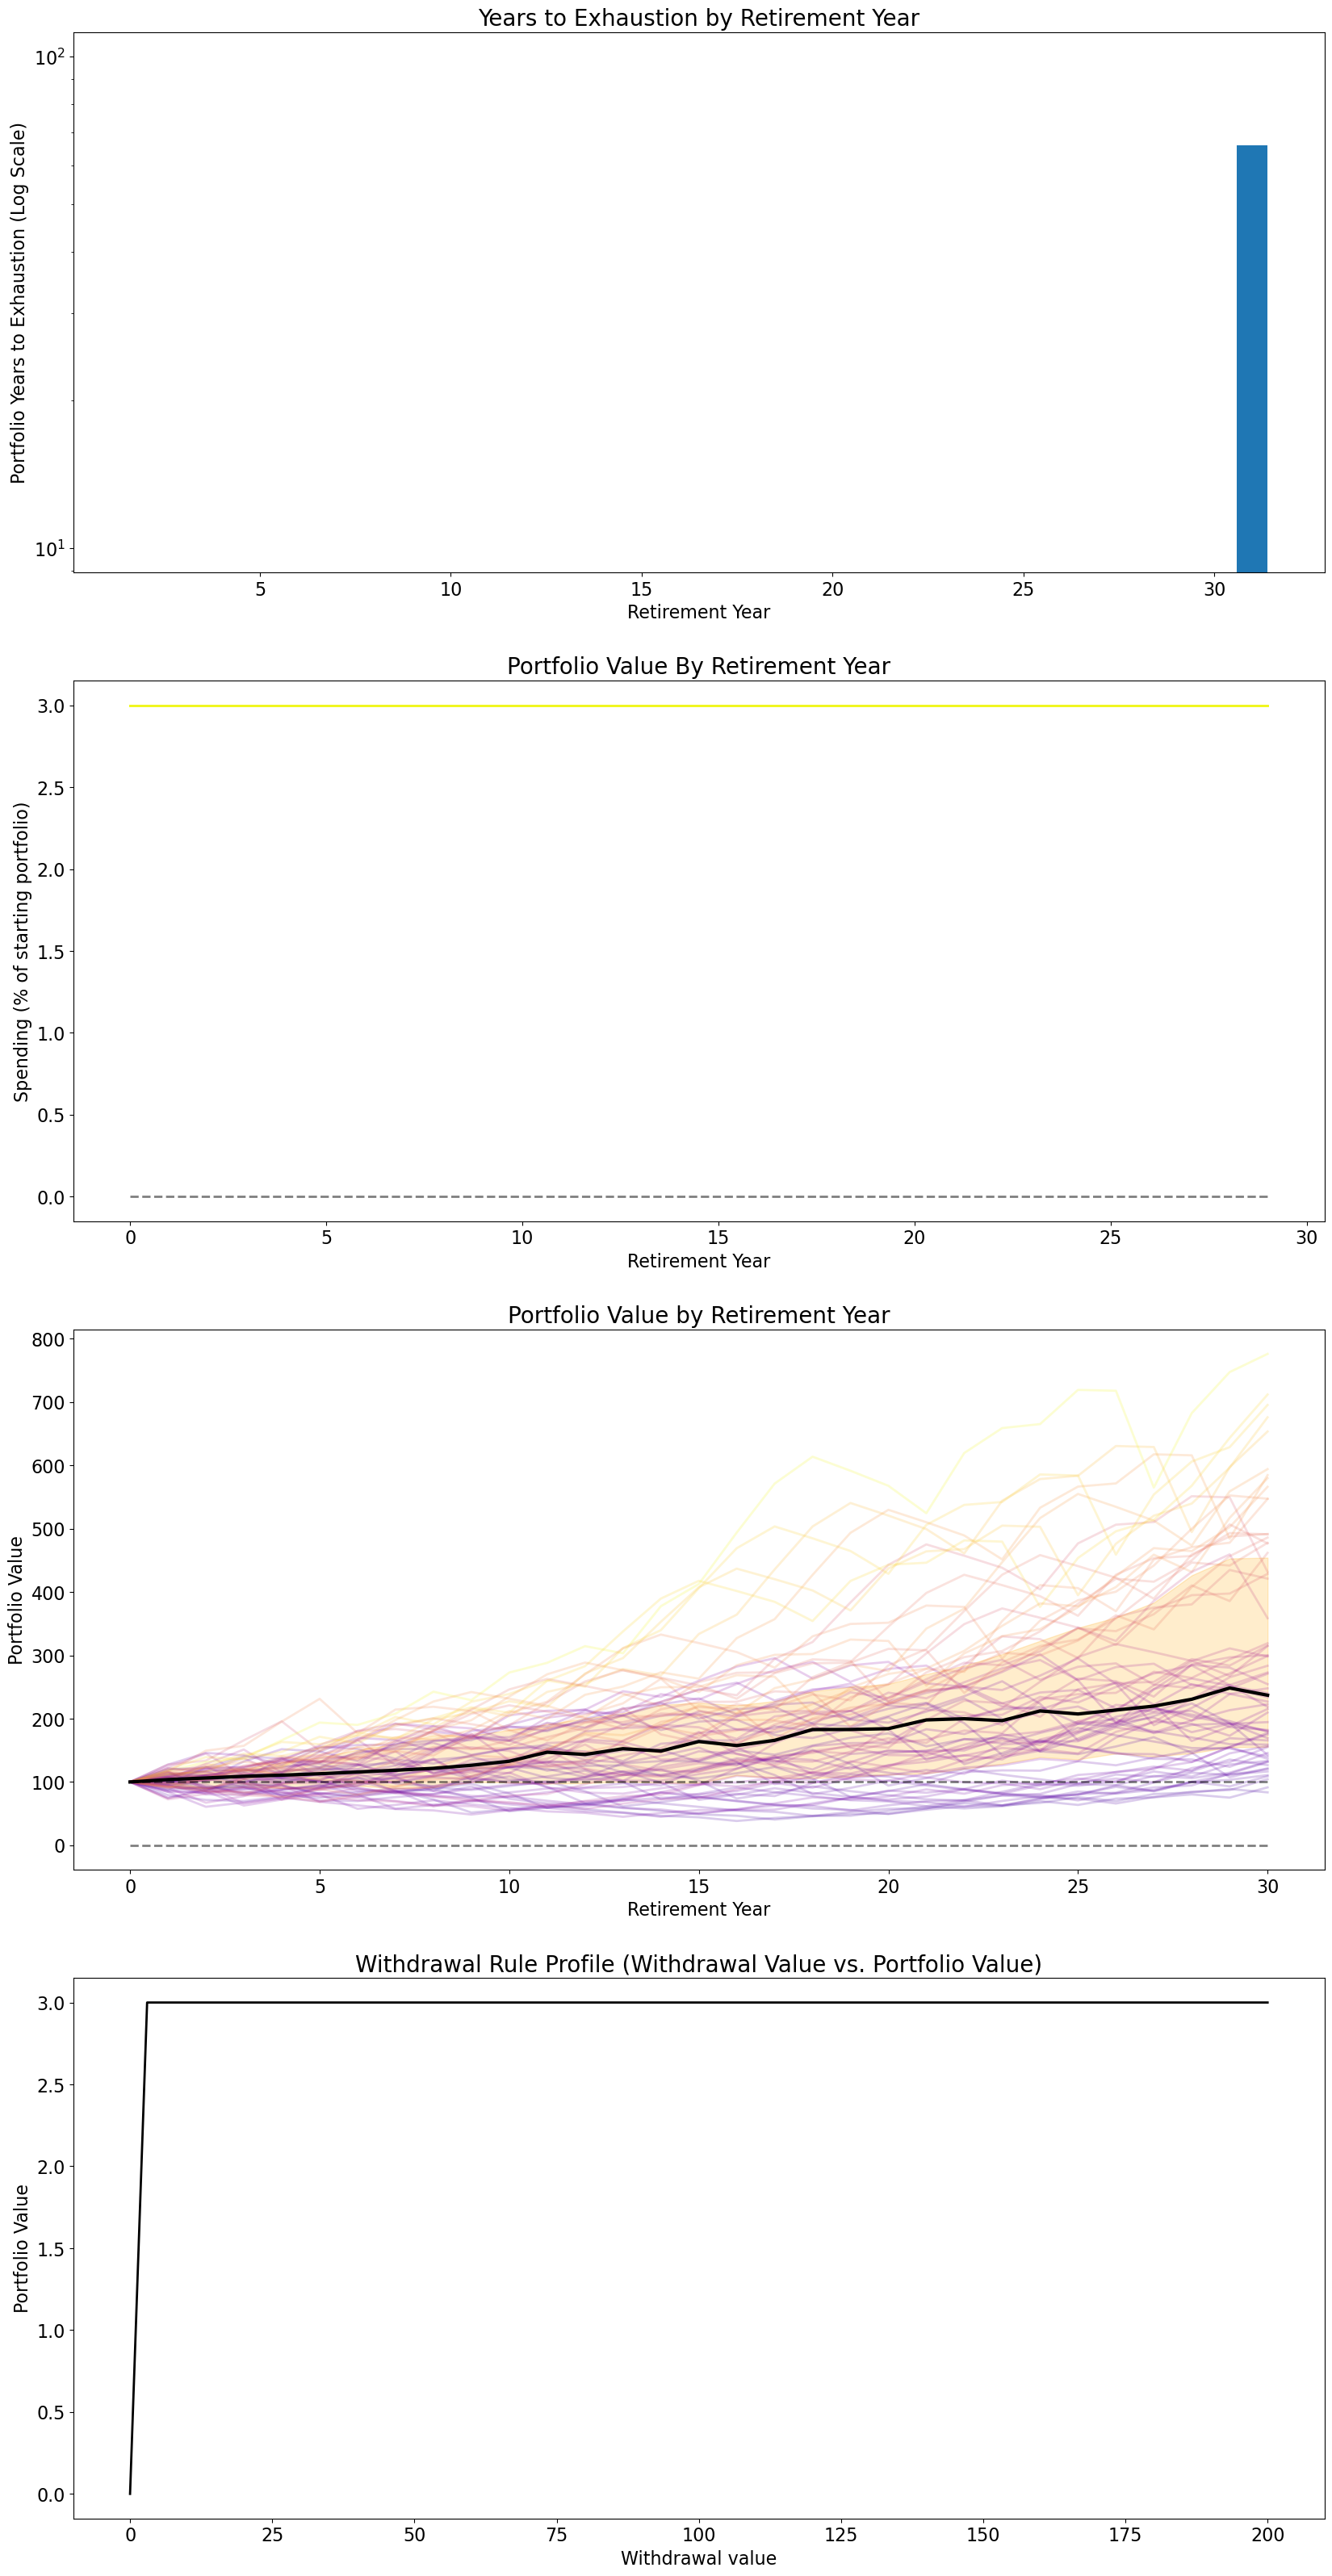

In [5]:
# Bengen 4% rule
VARIABLE_SPEND = 0.0
FIXED_SPEND = 3.0
STOCK_ALLOC = 0.50
BOND_ALLOC = 1 - STOCK_ALLOC
N_RET_YEARS = 30

s = SWRsimulationCE.SWRsimulationCE({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': N_RET_YEARS,
                  },
    'allocation': {'asset_weights': np.array([STOCK_ALLOC, BOND_ALLOC])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED_SPEND,
                   'variable_pct': VARIABLE_SPEND,
                   'floor_pct':0},
    'evaluation': {'gamma': 1}, 
    'visualization': {'histogram': True,
                      'chart_1' : {'title': 'Years to Exhaustion by Retirement Year'},
                      'chart_2' : {'title': 'Portfolio Spending By Retirement Year'},
                      'chart_2' : {'title': 'Portfolio Value By Retirement Year'},
                }    # chart options etc.
})

print(s)
s.simulate() # returns array of trials (by default all historical retirement periods)
s.visualize()  # chart of latest simulation

### MonteCarlo Analysis 

Instead of historical, do 1000 montecarlo trials

For each year of retirement, draw a random year from history to generate performance

Simulation:
{'montecarlo': 5000,
 'montecarlo_replacement': True,
 'n_asset_years': 95,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454932  0.044268
1929 -0.088311  0.024189
1930 -0.200079  0.074090
1931 -0.380674 -0.070178
1932  0.018184  0.377411
...        ...       ...
2018 -0.060220 -0.045852
2019  0.282803  0.127529
2020  0.164373  0.089279
2021  0.199522 -0.057578
2022 -0.229552 -0.196470

[95 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.montecarlo_trials at 0x146014c10>}

Allocation:
{'asset_weights': array([0.75, 0.25])}

Withdrawal:
{'fixed': 4.0,
 'fixed_pct': 4.0,
 'floor': 0.0,
 'floor_pct': 0,
 'invest_expense': 0.0,
 'variable': 0.0,
 'variable_pct': 0.0}


,metric,value
0,mean annual spending over all cohorts,3.89517633
1,mean within-cohort standard deviation of spending,0.16178117
2,lowest annual spending over all cohorts,0.00000000
3,minimum ending portfolio over all cohorts,0.00000000
4,% cohort portfolios exhausted by final year,10.46000000


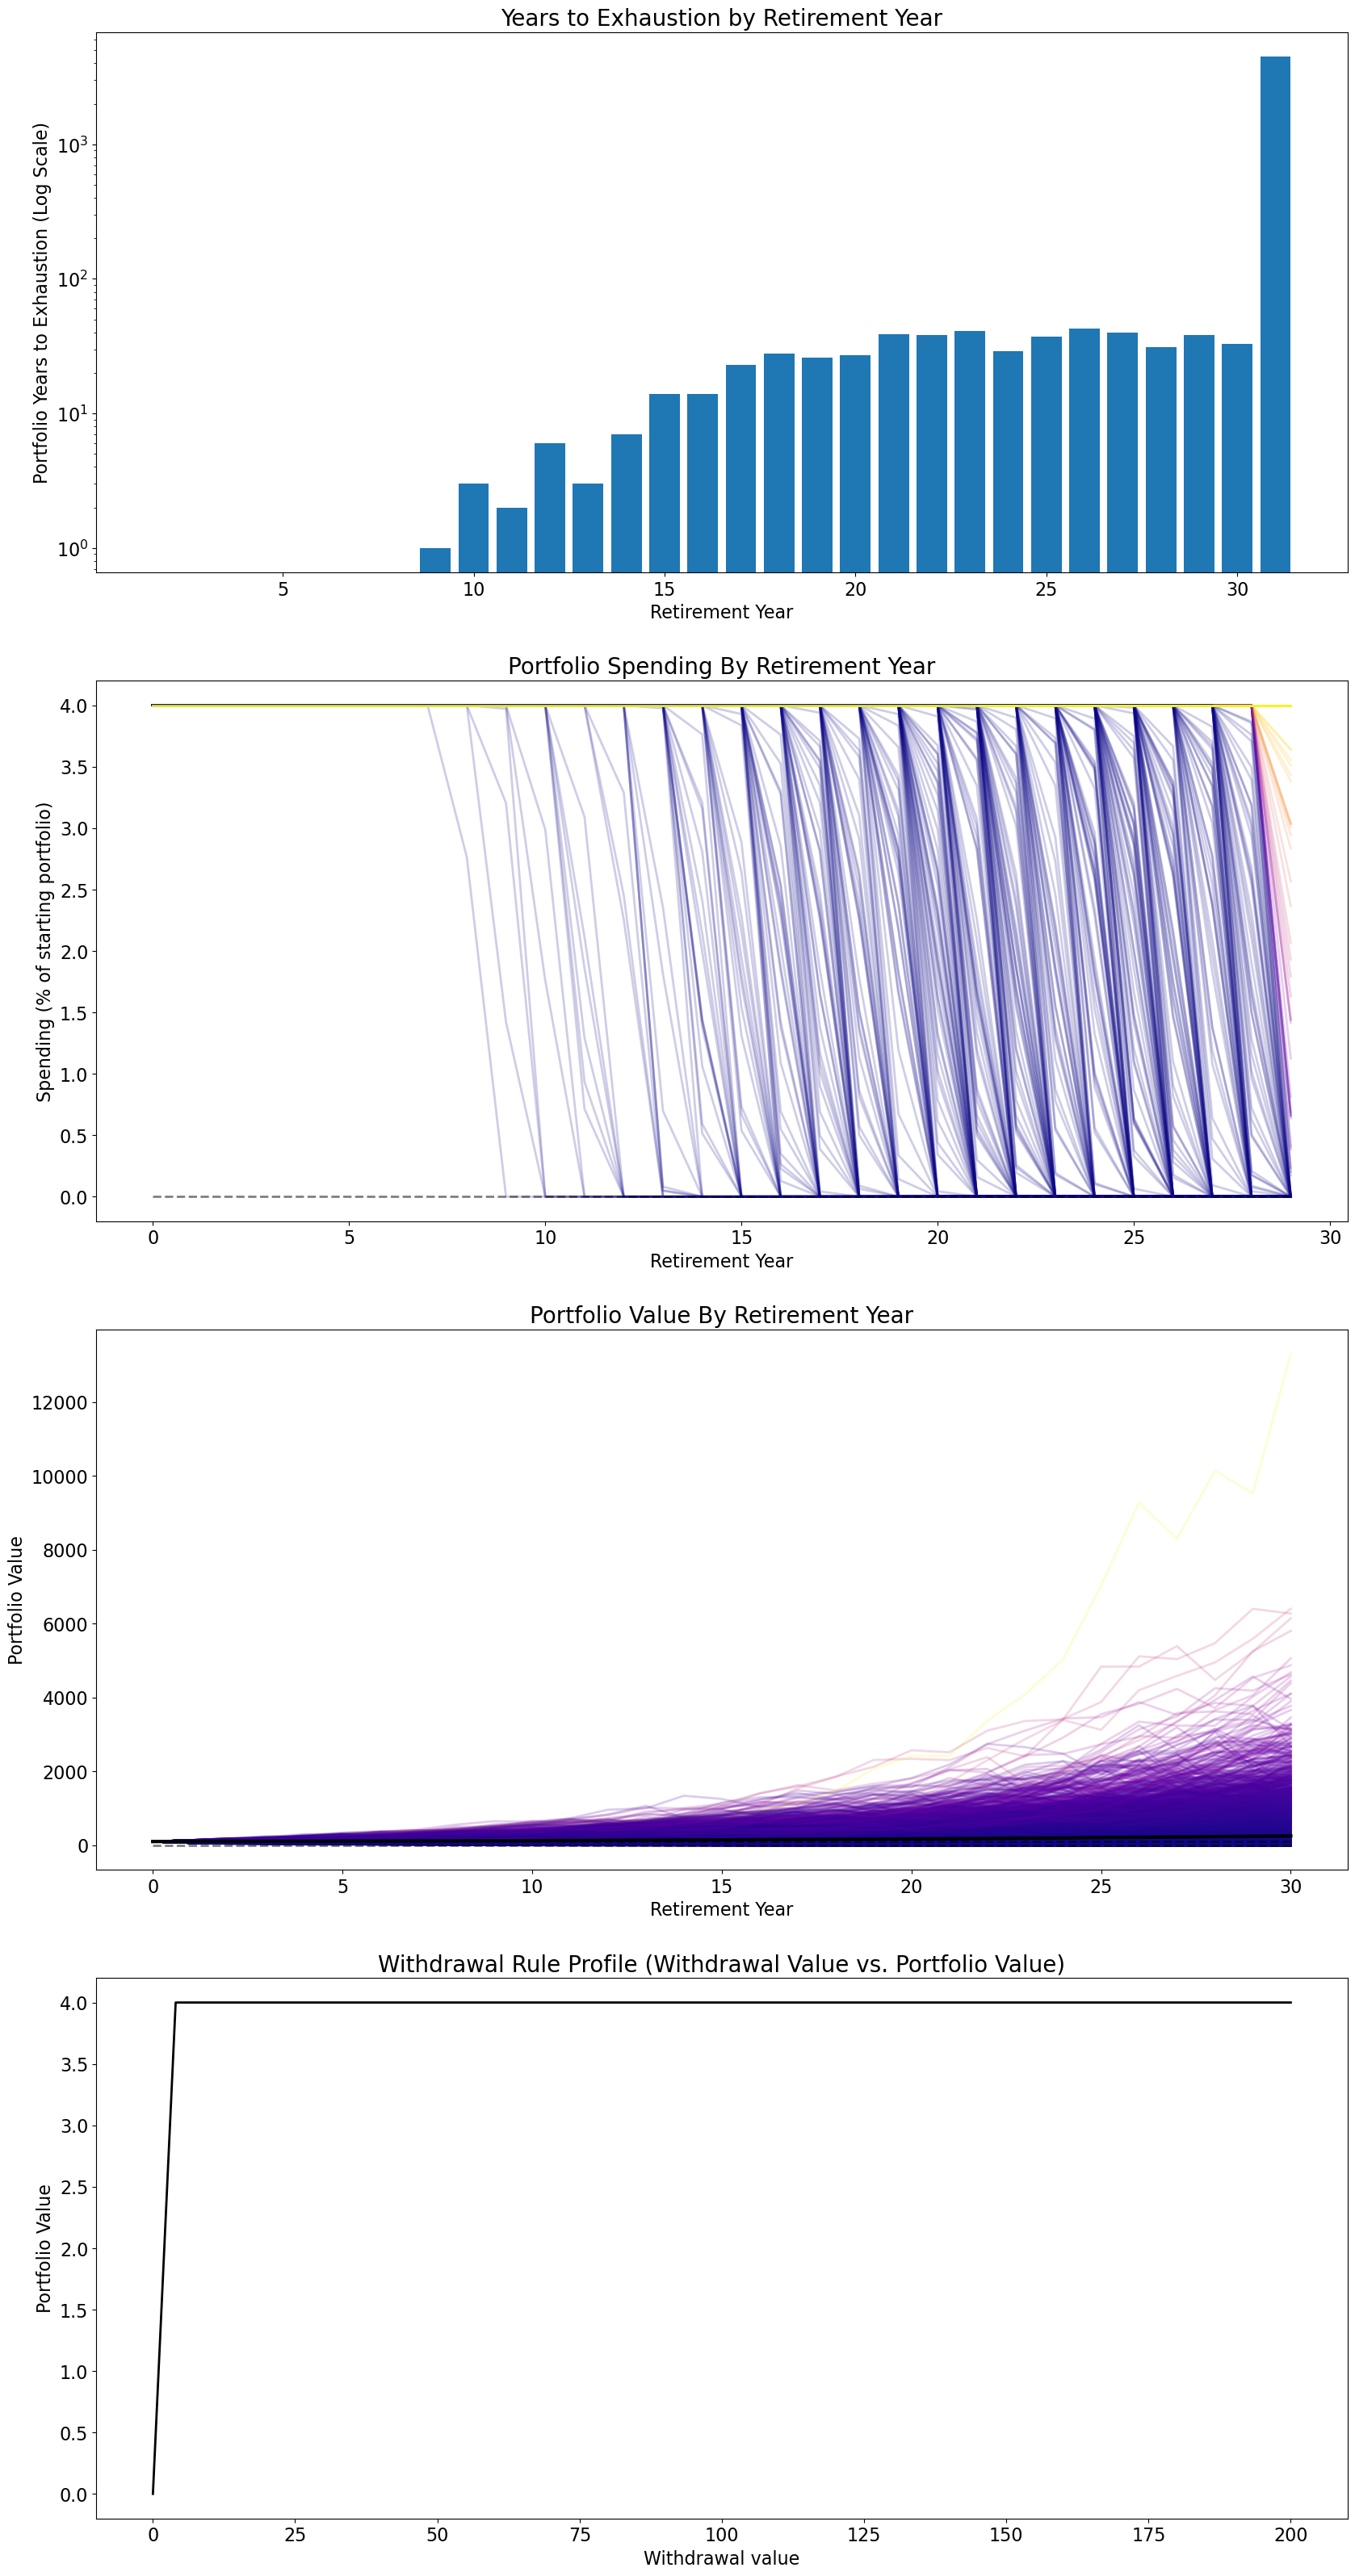

In [6]:
VARIABLE = 0.0
FIXED = 4.0
STOCK_ALLOC = 0.75
BOND_ALLOC = 1 - STOCK_ALLOC
N_RET_YEARS = 30
NTRIALS = 5000

s = SWRsimulationCE.SWRsimulationCE({
    'simulation': {'returns_df': real_return_df,
                   'montecarlo': NTRIALS,
                   'montecarlo_replacement': True,
                   'n_ret_years': N_RET_YEARS,
                  },
    'allocation': {'asset_weights': np.array([STOCK_ALLOC, BOND_ALLOC])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED,
                   'variable_pct': VARIABLE,
                   'floor_pct':0},
    'evaluation': {'gamma': 1}, 
    'visualization': {'histogram': True,
                      'chart_1' : {'title': 'Years to Exhaustion by Retirement Year'},
                      'chart_2' : {'title': 'Portfolio Spending By Retirement Year'},
                      'chart_3' : {'title': 'Portfolio Value By Retirement Year'},
                     }    # chart options etc.
})

print(s)

# don't keep 1000 historical arrays, just return a single eval for each trial
# eval is the years to exhaustion (30 if never exhausted)
s.simulate()
s.visualize()  # chart of latest simulation

### Fixed with Variable Withdrawl Strategy

Simulation:
{'n_asset_years': 95,
 'n_assets': 2,
 'n_ret_years': 35,
 'returns_df':         stocks     bonds
Year                    
1928  0.454932  0.044268
1929 -0.088311  0.024189
1930 -0.200079  0.074090
1931 -0.380674 -0.070178
1932  0.018184  0.377411
...        ...       ...
2018 -0.060220 -0.045852
2019  0.282803  0.127529
2020  0.164373  0.089279
2021  0.199522 -0.057578
2022 -0.229552 -0.196470

[95 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x146015460>}

Allocation:
{'asset_weights': array([0.54, 0.46])}

Withdrawal:
{'fixed': 3.0,
 'fixed_pct': 3.0,
 'floor': 0.0,
 'floor_pct': 0,
 'invest_expense': 0.0,
 'variable': 0.01,
 'variable_pct': 1.0}


,metric,value
0,mean annual spending over all cohorts,4.62583637
1,mean within-cohort standard deviation of spending,0.57045503
2,lowest annual spending over all cohorts,3.32865214
3,minimum ending portfolio over all cohorts,29.53656227
4,% cohort portfolios exhausted by final year,0.00000000


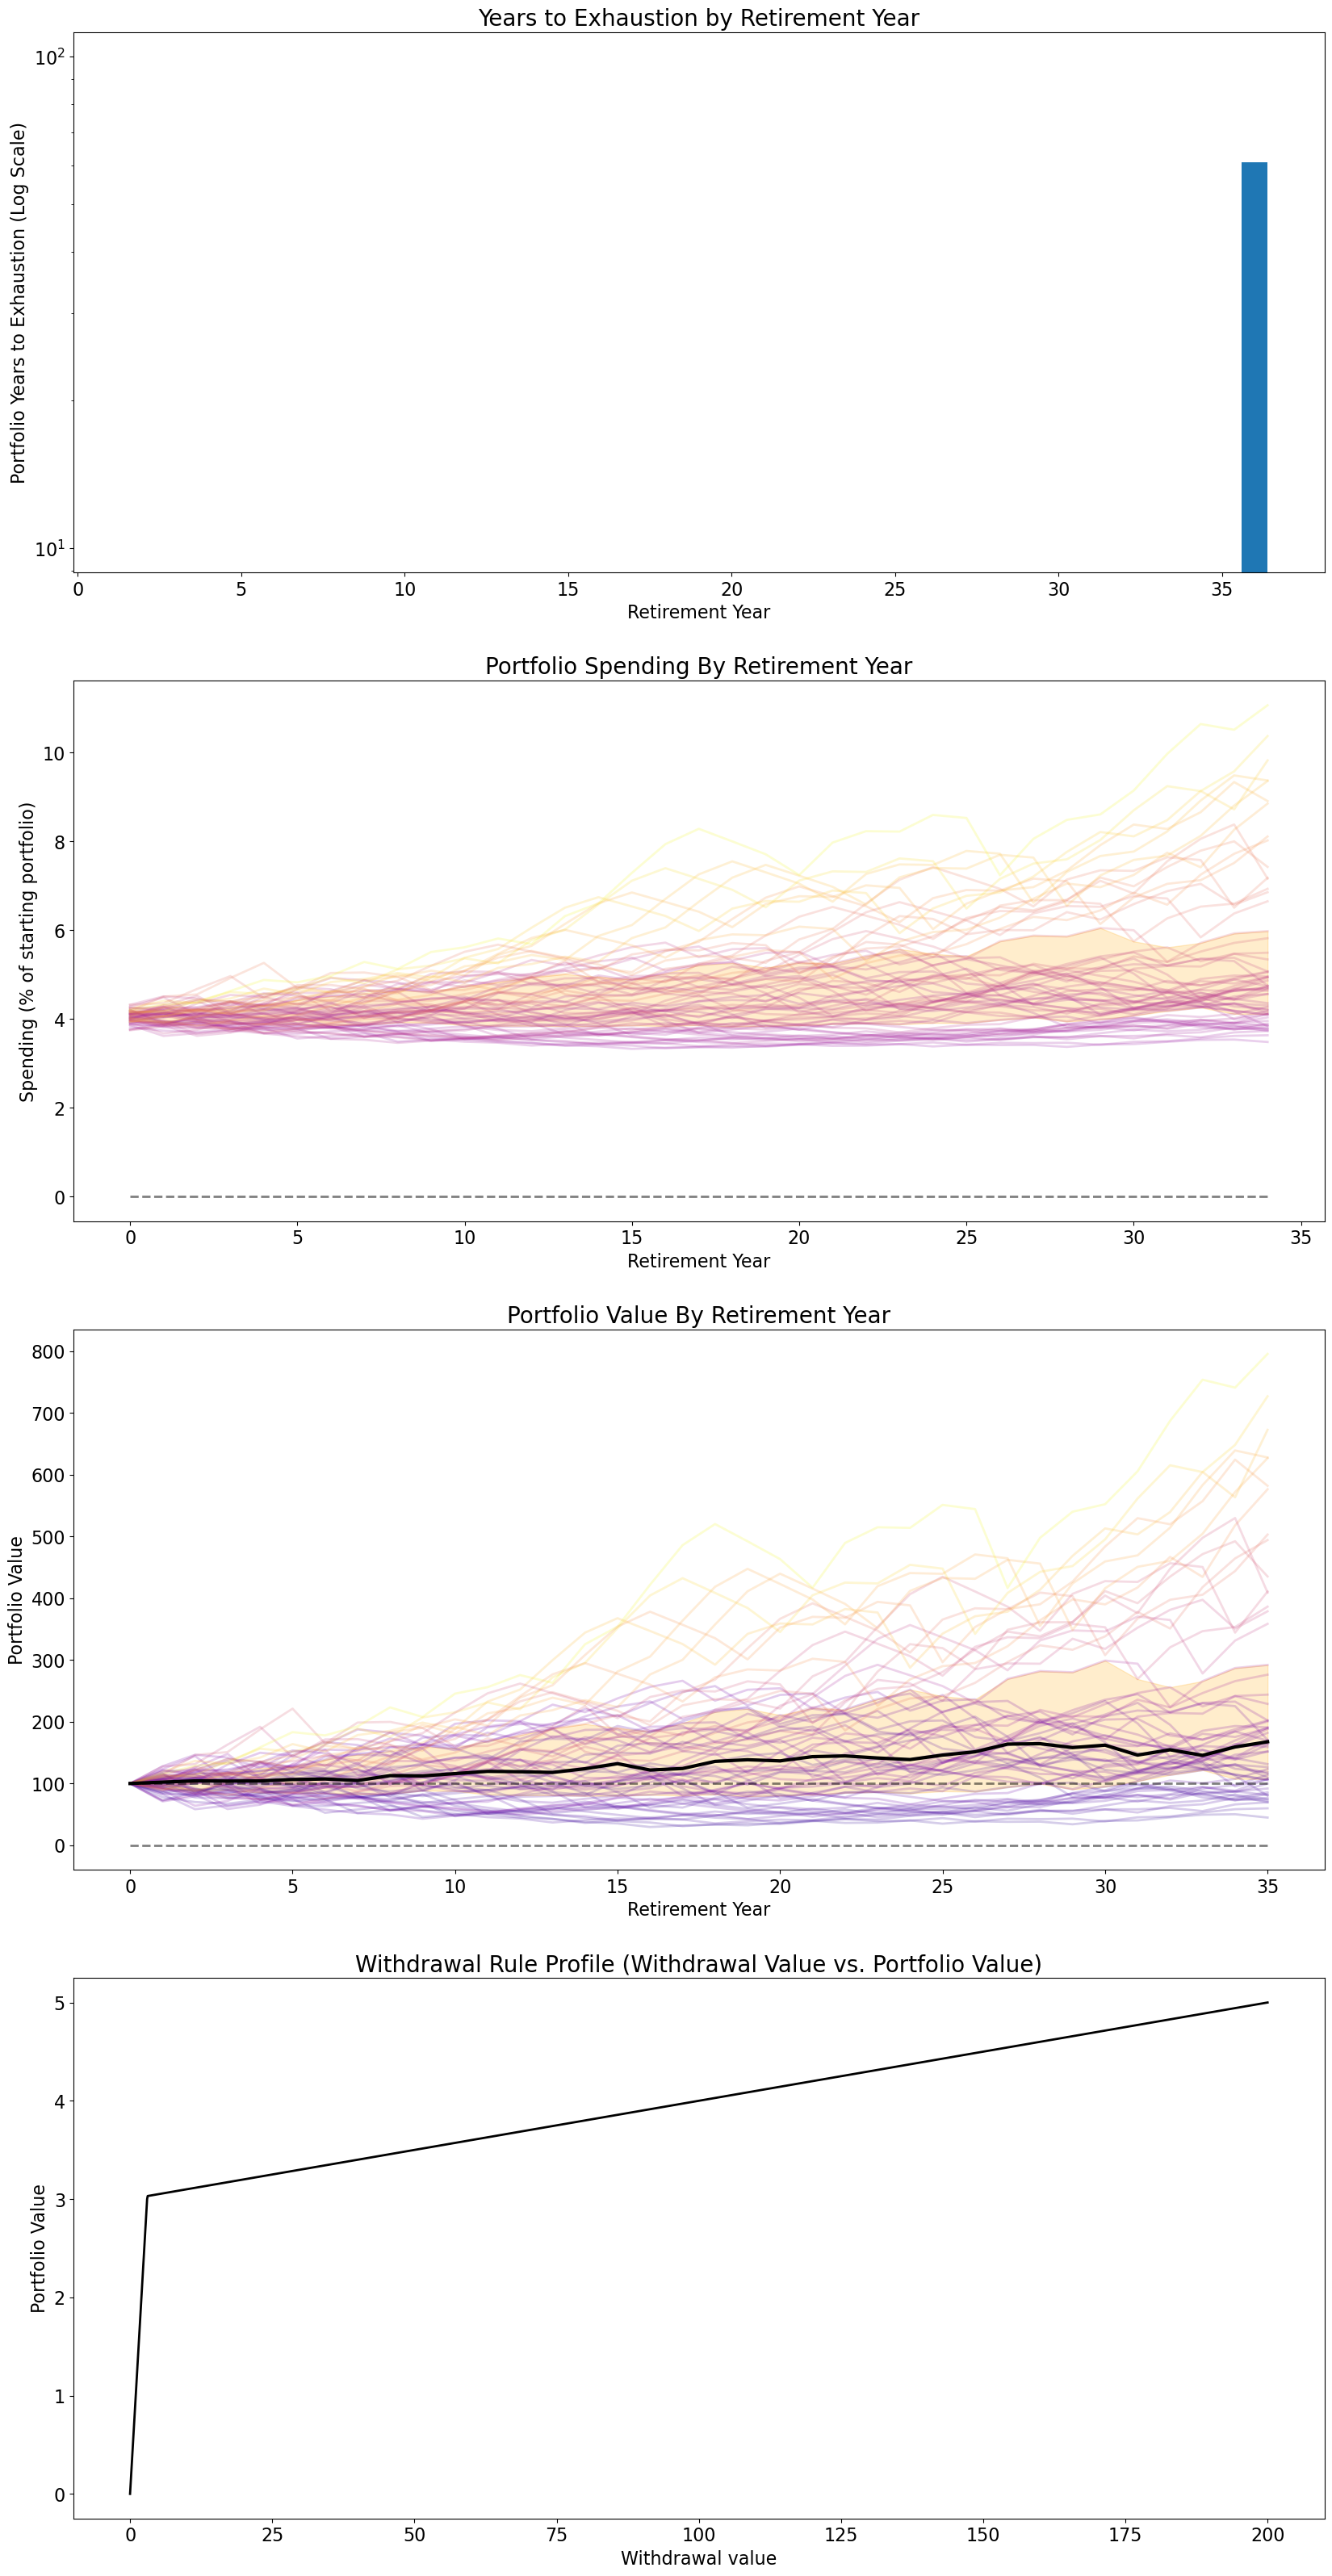

In [7]:
VARIABLE = 1.0
FIXED = 3.0
STOCK_ALLOC = 0.54
BOND_ALLOC = 1 - STOCK_ALLOC
N_RET_YEARS = 35

s = SWRsimulationCE.SWRsimulationCE({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': N_RET_YEARS,
                  },
    'allocation': {'asset_weights': np.array([STOCK_ALLOC, BOND_ALLOC])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED,
                   'variable_pct': VARIABLE,
                   'floor_pct':0},
    'evaluation': {'gamma': 1}, 
    'visualization': {'histogram': True,
                      'chart_1' : {'title': 'Years to Exhaustion by Retirement Year'},
                      'chart_2' : {'title': 'Portfolio Spending By Retirement Year'},
                      'chart_3' : {'title': 'Portfolio Value By Retirement Year'},
                     }    # chart options etc.
})

print(s)
s.simulate()
s.visualize()  # chart of latest simulation